# L11 - Uczenie reprezentacji

Na dzisiejszych zajęciach dowiemy się o paru metodach nauki reprezentacji (a nie gęstości danych), co może być przydatne do projektu (w szczególności autoenkodery).

Ref:
* (Repr. Learning, review) http://www.cl.uni-heidelberg.de/courses/ws14/deepl/BengioETAL12.pdf
* (Deep Learning book, ch. 15) http://www.deeplearningbook.org/
* (Autoenkodery w Keras) https://blog.keras.io/building-autoencoders-in-keras.html
* (Bardzo polecam, czego uczą się autoenkodery) https://gabgoh.github.io/ThoughtVectors/
* (Isomap) http://wearables.cc.gatech.edu/paper_of_week/isomap.pdf
* (Dobry opis konwolucyjnych sieci) http://cs231n.github.io/convolutional-networks/
* (Slajdy prof. Hintona na temat Isomap oraz tSNE) https://www.cs.toronto.edu/~hinton/csc2535/notes/lec11new.ppt
* (How to use tsne) http://distill.pub/2016/misread-tsne/

In [1]:
import matplotlib.pylab as plt
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets.samples_generator import make_swiss_roll
%matplotlib inline

In [2]:
import numpy as np
import sklearn
from sklearn.manifold import Isomap
from sklearn.decomposition import RandomizedPCA

In [3]:
!pip install tsne

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from tsne import bh_sne

In [5]:
from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

Using Theano backend.


# Zbiory danych

* Swissroll (2 -> 3)

* MNIST (? -> 784), ? pewnie nie dużo większe niż 30

In [6]:
## Swissroll
n_samples = 1500
noise = 0.05
X_swissroll, z_swissroll = make_swiss_roll(n_samples, noise)
X_swissroll[:, 1] *= .5
X_test_swissroll, z_test_swissroll = make_swiss_roll(n_samples/10, noise)
X_test_swissroll[:, 1] *= .5

In [69]:
## Swissroll noiseless
n_samples = 10000
noise = 0.00
X_swissroll_noiseless, z_swissroll = make_swiss_roll(n_samples, noise)
X_swissroll_noiseless[:, 1] *= 0.5
X_test_swissroll_noiseless, z_test_swissroll = make_swiss_roll(n_samples/10, noise)
X_test_swissroll_noiseless[:, 1] *= 0.5

In [7]:
## MNIST
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = mnist.load_data()
x_mnist_train = x_mnist_train.astype('float32') / 255.
x_mnist_test = x_mnist_test.astype('float32') / 255.
x_mnist_train = x_mnist_train.reshape((len(x_mnist_train), np.prod(x_mnist_train.shape[1:])))
x_mnist_test = x_mnist_test.reshape((len(x_mnist_test), np.prod(x_mnist_test.shape[1:])))

ids_train_small = np.random.choice(len(x_mnist_train), 1500, replace=False)
ids_test_small = np.random.choice(len(x_mnist_test), 1500, replace=False)
x_mnist_train_small = x_mnist_train[ids_train_small]
x_mnist_test_small = x_mnist_test[ids_test_small]
y_mnist_train_small = y_mnist_train[ids_train_small]
y_mnist_test_small = y_mnist_test[ids_test_small]

# Modele

In [8]:
from keras.layers.noise import GaussianNoise

In [98]:
def build_autoencoder(activation='relu', output_activation='sigmoid', hidden_dims=[32], input_dim=784, sigma=0.0):
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    
    if sigma > 0:
        input_enc = GaussianNoise(sigma)(input_img)
    else:
        input_enc = input_img
    
    # "encoded" is the encoded representation of the input
    x = input_enc
    for hidden_dim in hidden_dims:
        x = Dense(hidden_dim, activation=activation)(x)
    encoded = x
    for hidden_dim in reversed(hidden_dims[1:]):
        x = Dense(hidden_dim, activation=activation)(x)
        
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation=output_activation)(x)
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded 
    encoded_input = Input(shape=(hidden_dims[-1],))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [88]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

In [99]:
import keras.backend as K

# Postawienie problemu

## Odwracanie funkcji

Z jednej strony możemy patrzeć na problem uczenia nienadzorowanego jako problemu "odwrócenia" funkcji generującej dane.

Przykładowo, punkt ze zbioru danych swissroll powstaje przez wylosowanie 2 zmiennych $u_1$ oraz $u_2$ a potem ich zanurzeniu w 3 wymiarach. Ten proces staramy się odwrócić i znaleźć (nieliniowy) układ współrzędnych w którym swissroll "jest wypłaszczony".

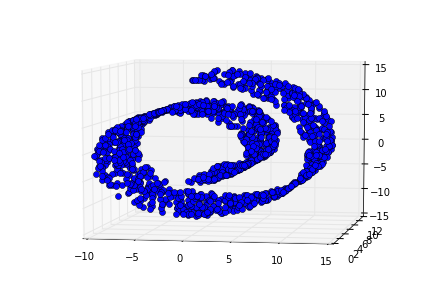

In [68]:
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
ax.plot3D(X_swissroll[:,0], X_swissroll[:, 1], X_swissroll[:, 2], 'o')

<img width=300 src="https://github.com/gmum/ml2017/raw/master/figures/L11/swissroll.png">

## Maximum likelihood

Z drugiej strony popularnym podejściem jest stawianie problemu uczenia nienadzorowanego jako znajdowania rozwiązania 

$$ \theta^{*} = argmax_{\theta} \mathbb{E}[p_\theta(x)] $$

Co istotne, jeśli naszym celem jest nauka cech (a nie aproksymacja gęstości), to nie ma zadnych gwarancji że podejścia typu "maximum likelihood" nauczą się ciekawych cech, patrz np. http://www.inference.vc/maximum-likelihood-for-representation-learning-2/.

# PCA / liniowy autoenkoder

Najprostsza sieć neuronowa do nauki cech jednocześnie implementuje PCA ("In the auto-associative case ... and therefore the unique locally and globally optimal map W is the orthogonal projection onto the space spanned by the first pp eigenvectors of ΣXX").

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/autoencoder_schema.jpg" width=500>

Dla liniowej funkcji enkoder metoda znajduje to samo co PCA:

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/pca.png" width=500>

Podstawowa idea: **utrata informacji**

## Swissroll

Wniosek: bardzo ciężko nauczyć się tak dobrej reprezentacji jak isomap 1 warstwowym enkoderem, ponieważ jest on i tak mocno liniowy

Train on 1500 samples, validate on 150 samples
Epoch 1/50
1500/1500 [==============================] - 0s - loss: 68.6069 - val_loss: 66.7762
Epoch 2/50
1500/1500 [==============================] - 0s - loss: 66.3182 - val_loss: 64.4262
Epoch 3/50
1500/1500 [==============================] - 0s - loss: 64.1127 - val_loss: 62.1725
Epoch 4/50
1500/1500 [==============================] - 0s - loss: 62.0042 - val_loss: 60.0216
Epoch 5/50
1500/1500 [==============================] - 0s - loss: 59.9836 - val_loss: 57.9652
Epoch 6/50
1500/1500 [==============================] - 0s - loss: 58.0492 - val_loss: 55.9983
Epoch 7/50
1500/1500 [==============================] - 0s - loss: 56.2013 - val_loss: 54.1197
Epoch 8/50
1500/1500 [==============================] - 0s - loss: 54.4283 - val_loss: 52.3210
Epoch 9/50
1500/1500 [==============================] - 0s - loss: 52.7316 - val_loss: 50.6020
Epoch 10/50
1500/1500 [==============================] - 0s - loss: 51.1079 - val_loss: 48.9586
Ep

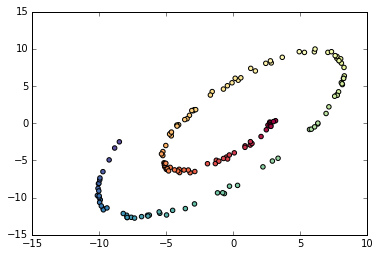

In [34]:
autoencoder, encoder, decoder = build_autoencoder(activation='linear', output_activation='linear',
                                                 hidden_dims=[2], input_dim=3)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(X_swissroll, X_swissroll,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(X_test_swissroll, X_test_swissroll))

# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
X_test_swissroll_proj = encoder.predict(X_test_swissroll)

plt.scatter(X_test_swissroll_proj[:, 0], X_test_swissroll_proj[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## MNIST

In [ ]:
## Najpierw narysujmy przestrzeń 2d

[]

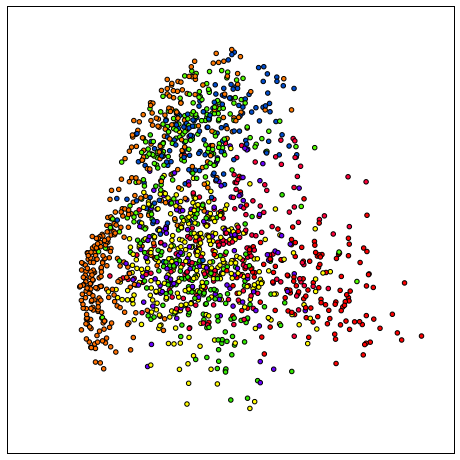

In [87]:
pca = RandomizedPCA(n_components=2, iterated_power=15, whiten=True)
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()
x_mnist_train_transformed_small = pca.fit_transform(x_mnist_train_small.reshape(x_mnist_train_small.shape[0], -1))
plot.scatter(x_mnist_train_transformed_small[:, 0], x_mnist_train_transformed_small[:, 1], c=y_mnist_train_small)
plot.set_xticks(())
plot.set_yticks(())

In [ ]:
## Teraz rozważmy hidden dim > 2

In [23]:
autoencoder, encoder, decoder = build_autoencoder(activation='linear', output_activation='sigmoid',
                                                 hidden_dim=32, input_dim=784)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_mnist_train, x_mnist_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_mnist_test, x_mnist_test))

encoded_imgs = encoder.predict(x_mnist_test)
decoded_imgs = decoder.predict(encoded_imgs)

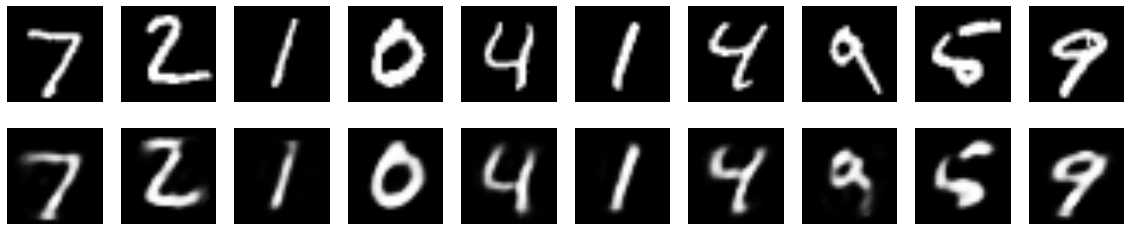

In [31]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Samplowanie

Poza uczeniem się cech, wiele modeli pozwala na efektywne "wymyślanie" (generowanie) przykładów. W niektórych modelach jest to trudne, w innych proste. W przypadku typowych autoenkoderów możliwa jest interpolacja między przykładami.

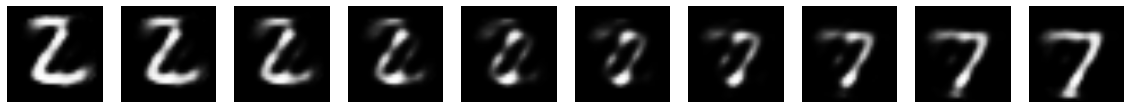

In [39]:
# Policzmy interpolacje miedzy 7 a 2 ze zbioru testowego
interpolated = []
n = 10
plt.figure(figsize=(20, 4))
for i, lerp in enumerate(np.linspace(0, 1, n)):
    interpolated.append(decoder.predict(lerp*encoded_imgs[0:1] + (1-lerp)*encoded_imgs[1:2]))
    
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(interpolated[-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Problemy PCA / liniowego autoenkodera

* Brak modelu prawdopodobieństwa (0 poza nieskończonie małym podzbiorem) - Probabilistic PCA (PPCA), patrz np. http://edwardlib.org/tutorials/probabilistic-pca oraz variational/denoising autoenckoder
* Ciężko generować z modeli (rozwiązywane przez VAE/PPCA)
* Zakłada globalną strukture euklidesową - MDS generalizuje na dowolną metryke
* Zakłada globalną strukturę liniową - Isomap/LLE/kernelPCA/nieliniowe autoenkodery wszystkie rozwiązać ten problem

# Isomap

Isomap jest w pewnym sensie rozszerzeniem PCA do izometrycznych odzworowań (solver w scikit-learn używa kernel PCA wewnątrz). Dalsze modyfikacje rozszerzają do odwzorowań konforemnych (zachowujących kąty). Przez "rozszerzenie" rozumiemy tutaj, że Isomap rozwiązuje problem szukania odwzorowania odwrotnego przy odpowiednio dużej ilości punktów (podczas gdy PCA nigdy nie rozwiąże swissroll, nawet przy nieskończonej próbce danych).

* Isomap w tradycyjnym sformułowaniu nie pozwala na predykcję na nowych punkach (czyli np. samplowanie).

* Isomap ma złożoność O(n^3) przez co niestety jest bardziej ciekawostką, za to całkiem podobne algorytmy, np. t-SNE są dużo szybsze.

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/isomap_distance.png" width=800>

"PCA
finds a low-dimensional embedding of the
data points that best preserves their variance
as measured in the high-dimensional input
space. Classical MDS finds an embedding
that preserves the interpoint distances, equivalent
to PCA when those distances are Euclidean.
However, many data sets contain
essential nonlinear structures that are invisible
to PCA and MDS (4, 5, 11, 14). For
example, both methods fail to detect the true
degrees of freedom of the face data set (Fig.
1A), or even its intrinsic three-dimensionality
(Fig. 2A)."

"Just as PCA and MDS are guaranteed,
given sufficient data, to recover the true
structure of linear manifolds, Isomap is guaranteed
asymptotically to recover the true dimensionality
and geometric structure of a
strictly larger class of nonlinear manifolds"

(Cytaty z http://wearables.cc.gatech.edu/paper_of_week/isomap.pdf)


## Swissroll

Isomap, odwrotnie od PCA/liniowego autoenkodera rozwiązuje całkiem nieźle swissroll

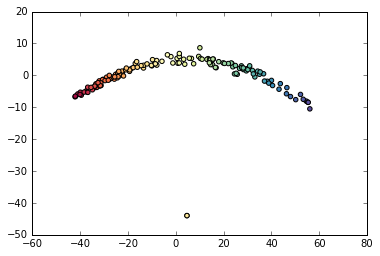

In [89]:
isomap = Isomap().fit(X_swissroll)
X_test_swissroll_proj = isomap.transform(X_test_swissroll)
# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
plt.scatter(X_test_swissroll_proj[:, 0], X_test_swissroll_proj[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## MNIST

[]

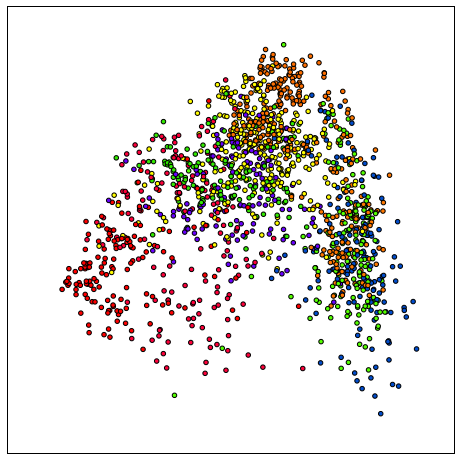

In [88]:
## Isomap na MNIST wizualnie wydaje sie podobny, ale dalsze eksperymenty (samplowanie) pokazuje że jest zwykle lepszy

isomap = Isomap()
fig, plot = plt.subplots()
fig.set_size_inches(8, 8)
plt.prism()
x_mnist_train_transformed_small = isomap.fit_transform(x_mnist_train_small.reshape(x_mnist_train_small.shape[0], -1))
plot.scatter(x_mnist_train_transformed_small[:, 0], x_mnist_train_transformed_small[:, 1], c=y_mnist_train_small)
plot.set_xticks(())
plot.set_yticks(())

## Samplowanie

Orginalny isomap nie pozwala, ale są rozszerzenia. Jak widać (z pracy http://web.mit.edu/cocosci/Papers/sci_reprint.pdf) samplowanie  jest bardziej naturalne (porównaj z wykresem z sekcji o PCA):

<img src="https://github.com/gmum/ml2017/raw/master/figures/L11/sampling_isomap.png" width=500>

# t-SNE

t-SNE służy do wizualizacji, nie nauki cech! Jest zamieszczony ze względu na ogromną popularność.

Ref: http://distill.pub/2016/misread-tsne/

Różnice z isomap: 
* crowding problem (high dim -> 2 powoduje nowe problemy)
* O(n^2), a nawet O(nlgn) (w porównaniu do złożonosci sześciennej podstawowej wersji Isomap)

Parametry (ważne):
* Learning rate
* Perplexity

"A second feature of t-SNE is a tuneable parameter, “perplexity,” which says (loosely) how to balance attention between local and global aspects of your data. The parameter is, in a sense, a guess about the number of close neighbors each point has. The perplexity value has a complex effect on the resulting pictures. The original paper says, “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.” But the story is more nuanced than that. Getting the most from t-SNE may mean analyzing multiple plots with different perplexities."

TODO: Przekrój

## Swissroll

Dla roznych perplexities

In [57]:
perplexities = [2, 5, 10, 20, 50, 100]

(0, 2)
(1, 5)
(2, 10)
(3, 20)
(4, 50)
(5, 100)


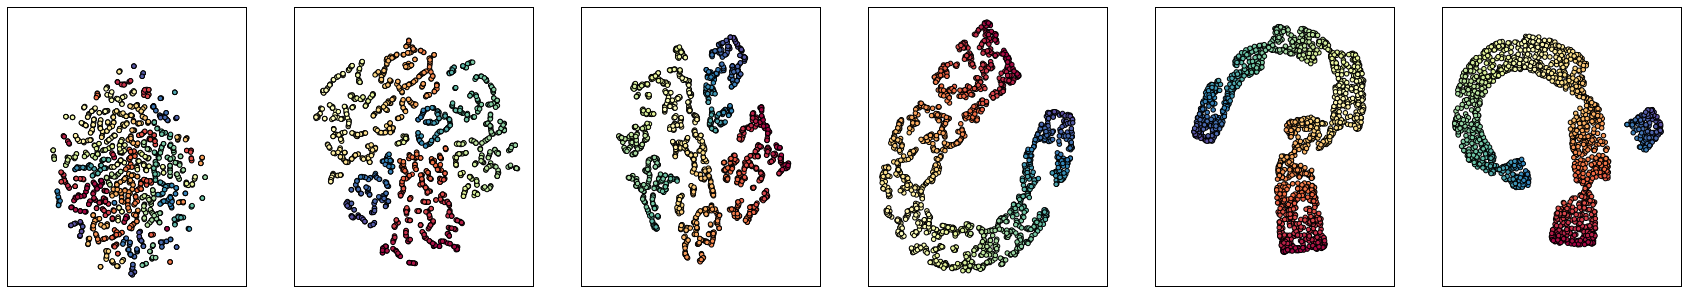

In [61]:
# Policzmy interpolacje miedzy 7 a 2 ze zbioru testowego
# Prosze zwrocic na oderwanie ostatniego kawalka na ostatnim z prawej obrazku

interpolated = []
n = len(perplexities)
plt.figure(figsize=(len(perplexities) * 5, 5))
for i, p in enumerate(perplexities):
    print((i, p))
    ax = plt.subplot(1, n, i + 1)
    X_swissroll_proj = bh_sne(X_swissroll.astype("float64"), perplexity=p)
    plt.scatter(X_swissroll_proj[:, 0], X_swissroll_proj[:, 1], c=z_swissroll, cmap=plt.cm.Spectral)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Zadanie [1 pkt]

Czemu ostatni obrazek z prawej (dla maksymalnego perplexity) ma oderwany kawalek?

## MNIST

t-SNE ma też problemy z "surowymi" danymi (nie jest to metoda nauki reprezentacji). Jak zobaczymy w ćwiczeniu, t-SNE za to działa świetnie do wizualizacji już nauczonych cech.

In [62]:
# Dla t-sne srednia nie jest istotna, ale skala tak
x_mnist_train_small_standardized = x_mnist_train_small/ (1e-10 + np.std(x_mnist_train_small, axis=0, keepdims=True))

(0, 2)
(1, 5)
(2, 10)
(3, 20)
(4, 50)
(5, 100)


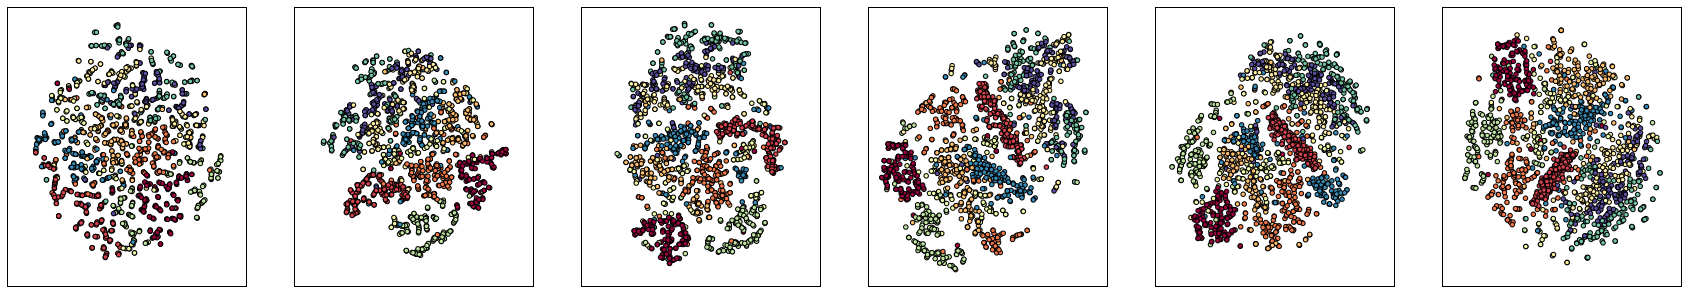

In [64]:
# Policzmy interpolacje miedzy 7 a 2 ze zbioru testowego
interpolated = []
n = len(perplexities)
plt.figure(figsize=(len(perplexities) * 5, 5))
for i, p in enumerate(perplexities):
    print((i, p))
    ax = plt.subplot(1, n, i + 1)
    x_mnist_train_small_standardized_proj = bh_sne(x_mnist_train_small_standardized.astype("float64"), perplexity=p)
    plt.scatter(x_mnist_train_small_standardized_proj[:, 0], x_mnist_train_small_standardized_proj[:, 1], 
                c=y_mnist_train_small, cmap=plt.cm.Spectral)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Nieliniowy autoenkoder

Ref: http://gabgoh.github.io/ThoughtVectors/, https://blog.keras.io/building-autoencoders-in-keras.html

Podstawowa idea: utrata informacji

## Swissroll

Wniosek: mimo dobrej dokładnośc (MSE) ciężko znaleźć poprawne cechy dla zbioru danych swissroll. 

1. Koszt autoenkodera nie jest tym samym co znajdowanie dobrych cech (3 cechy też dobrze kodują).

2. Transformacja ktora znajduje rozplątanie jest bardzo nieliniowa

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
std = StandardScaler().fit(X_swissroll)
X_test_swissroll_std = std.transform(X_test_swissroll)
X_swissroll_std = std.transform(X_swissroll)

In [70]:
std = StandardScaler().fit(X_swissroll_noiseless)
X_test_swissroll_noiseless_std = std.transform(X_test_swissroll_noiseless)
X_swissroll_noiseless_std = std.transform(X_swissroll_noiseless)

In [86]:
# Blad MSE 0.3 jest calkiem dobry

autoencoder, encoder, decoder = build_autoencoder(activation='tanh', output_activation='linear',
                                                 hidden_dims=[15, 2], input_dim=3, sigma=0.1)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(X_swissroll_noiseless_std, X_swissroll_noiseless_std,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(X_test_swissroll_noiseless_std, X_test_swissroll_noiseless_std))

# Jak widac, swissroll nie ma globalnej struktury liniowej, stad porazka metody
X_test_swissroll_noiseless_std_proj = encoder.predict(X_test_swissroll_noiseless_std)

Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 0s - loss: 0.6511 - val_loss: 0.4939
Epoch 2/100
10000/10000 [==============================] - 0s - loss: 0.4205 - val_loss: 0.3887
Epoch 3/100
10000/10000 [==============================] - 0s - loss: 0.3717 - val_loss: 0.3640
Epoch 4/100
10000/10000 [==============================] - 0s - loss: 0.3557 - val_loss: 0.3541
Epoch 5/100
10000/10000 [==============================] - 0s - loss: 0.3487 - val_loss: 0.3493
Epoch 6/100
10000/10000 [==============================] - 0s - loss: 0.3447 - val_loss: 0.3465
Epoch 7/100
10000/10000 [==============================] - 0s - loss: 0.3422 - val_loss: 0.3444
Epoch 8/100
10000/10000 [==============================] - 0s - loss: 0.3406 - val_loss: 0.3431
Epoch 9/100
10000/10000 [==============================] - 0s - loss: 0.3390 - val_loss: 0.3420
Epoch 10/100
10000/10000 [==============================] - 0s - loss: 0.3379 - val_los

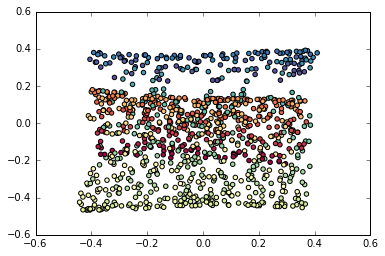

In [87]:
plt.scatter(X_test_swissroll_noiseless_std_proj[:, 0], X_test_swissroll_noiseless_std_proj[:, 1], c=z_test_swissroll, cmap=plt.cm.Spectral)

## Interrim - konwolucje

Ref: http://cs231n.github.io/convolutional-networks/

<img src="figures/L11/conv1.jpeg" width=500>

(Wersja animowana dostępna na http://cs231n.github.io/convolutional-networks/)

<img src="figures/L11/conv3.png" width=500>

## MNIST

(Rozważamy tutaj konwolucje, patrz wykład)

In [123]:
from keras.layers import Flatten

In [124]:
def build_conv_autoencoder(activation='relu', output_activation='sigmoid', hidden_dims=[32], width=28, height=28, sigma=0.0):
    # this is our input placeholder
    input_img = Input(shape=(width, height, 1))
    
    if sigma > 0:
        input_enc = GaussianNoise(sigma)(input_img)
    else:
        input_enc = input_img
    
    # "encoded" is the encoded representation of the input
    x = input_enc
    for hidden_dim in hidden_dims:
        x = Conv2D(hidden_dim, (3,3), activation=activation,  padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = x
    for hidden_dim in reversed(hidden_dims):
        x = Conv2D(hidden_dim, (3,3), activation=activation,  padding='same')(x)
        x = UpSampling2D((2, 2))(x)
    # "decoded" is the lossy reconstruction of the input
    decoded = Conv2D(1, (3, 3), padding="same", activation=output_activation)(x)
    print(K.int_shape(decoded))
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    print(K.int_shape(encoded))
    # create a placeholder for an encoded 
    encoded_input = Input(shape=K.int_shape(encoded)[1:])
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [125]:
autoencoder, encoder, decoder = build_conv_autoencoder(activation='relu', output_activation='sigmoid',
                                                 hidden_dims=[16, 8, 8], width=28, height=28)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(None, 32, 32, 1)
(None, 4, 4, 8)


ValueError: Input 0 is incompatible with layer conv2d_92: expected axis -1 of input shape to have value 16 but got shape (None, 4, 4, 8)

In [ ]:

autoencoder.fit(x_mnist_train, x_mnist_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_mnist_test, x_mnist_test))

encoded_imgs = encoder.predict(x_mnist_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Zadanie 1 - nieliniowy autoenkoder na CIFAR10/MNIST [5 pkt]

1. Sprawdź jak wygląda interpolacja dla CIFAR10 (patrz projekt.ipynb) i MNIST dla nieliniowego autoenkodera. [2 pkt]
2. Narysuj wykres t-SNE przestrzeni latent (encoder(CIFAR10_test)) z zaznaczonym interpolowanymi punktami za czerwono. [2 pkt]
3. Czy można policzyć likelihood danych wg. rozważanego nieliniowego autoenkodera? [1pkt]

# O czym nie wspominamy

* Klastrowanie (w szczególności spectral clustering)
* GAN 
* kernel PCA / probabilistic PCA